In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import os
from torchvision.models import inception_v3
from scipy.linalg import sqrtm
from torchsummary import summary as Summary

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

latent_dim = 128
batch_size = 64
lr = 5e-5
img_shape = (3, 32, 32)
n_epochs = 30
n_critic = 5
c = 0.01
l = 10

print(device)

cuda


In [4]:
import torch
import torch.nn.functional as F
from torchvision.models import inception_v3
from torch.utils.data import DataLoader
import numpy as np
from scipy.linalg import sqrtm

# Load two separate models for efficiency
# Model for features (FID)
inception_fid = inception_v3(pretrained=True, transform_input=False)
inception_fid.fc = torch.nn.Identity()  # Remove final classification layer
inception_fid.aux_logits = False
inception_fid.eval()

# Model for predictions (IS)
inception_is = inception_v3(pretrained=True, transform_input=False)
inception_is.aux_logits = False
inception_is.eval()

if torch.cuda.is_available():
    inception_fid = inception_fid.cuda()
    inception_is = inception_is.cuda()

def preprocess_images(images):
    """Preprocess images for Inception-v3"""
    # Ensure images are in [0, 1] range
    if images.min() >= -1.0 and images.max() <= 1.0:
        # Input is in [-1, 1] range (GAN output)
        images = (images + 1.0) / 2.0
    elif images.max() > 1.0:
        # Input is in [0, 255] range
        images = images / 255.0
    else:
        # Already in [0, 1] range
        pass

    # Clamp to [0, 1]
    images = torch.clamp(images, 0.0, 1.0)

    # Resize to 299x299
    images = F.interpolate(images, size=(299, 299), mode='bilinear', align_corners=False)

    # ImageNet normalization
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)

    if images.is_cuda:
        mean = mean.cuda()
        std = std.cuda()

    images = (images - mean) / std
    return images

def get_features(images, model):
    """Extract 2048-dim features from Inception-v3 for FID calculation"""
    model.eval()
    with torch.no_grad():
        if torch.cuda.is_available():
            images = images.cuda()

        # Preprocess images
        images = preprocess_images(images)

        # Forward pass - model.fc is Identity, so this gives us 2048-dim features
        features = model(images)

        # Ensure features are 2D (batch_size, 2048)
        if len(features.shape) == 4:
            features = F.adaptive_avg_pool2d(features, (1, 1))
            features = torch.flatten(features, 1)

    return features.cpu()

def get_predictions(images, model):
    """Extract softmax predictions from Inception-v3 for IS calculation"""
    model.eval()
    with torch.no_grad():
        if torch.cuda.is_available():
            images = images.cuda()

        # Preprocess images
        images = preprocess_images(images)

        # Forward pass - model.fc is intact, so this gives us logits
        logits = model(images)
        preds = F.softmax(logits, dim=1)

    return preds.cpu()

def calculate_stats(features):
    """Calculate mean and covariance matrix of features"""
    features = features.numpy().astype(np.float64)  # Use float64 for numerical stability
    mu = np.mean(features, axis=0)
    sigma = np.cov(features, rowvar=False)
    return mu, sigma

def calculate_fid(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Calculate FID score between two sets of features"""
    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    # Ensure matrices are symmetric (numerical stability)
    sigma1 = (sigma1 + sigma1.T) / 2
    sigma2 = (sigma2 + sigma2.T) / 2

    # Add small epsilon to diagonal for numerical stability
    sigma1 += eps * np.eye(sigma1.shape[0])
    sigma2 += eps * np.eye(sigma2.shape[0])

    diff = mu1 - mu2

    # Calculate sqrt of product of covariance matrices
    try:
        covmean, _ = sqrtm(sigma1.dot(sigma2), disp=False)
    except Exception as e:
        print(f"Error in sqrtm: {e}")
        # Fallback: add more regularization
        sigma1 += eps * 10 * np.eye(sigma1.shape[0])
        sigma2 += eps * 10 * np.eye(sigma2.shape[0])
        covmean, _ = sqrtm(sigma1.dot(sigma2), disp=False)

    # Handle numerical errors in sqrtm
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.absolute(covmean.imag))
            raise ValueError(f"Imaginary component {m}")
        covmean = covmean.real

    fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid

def compute_inception_score(preds, splits=10):
    """Compute Inception Score from predictions"""
    N = preds.size(0)

    # Ensure we have enough samples for splits
    if N < splits:
        splits = N

    split_scores = []

    for k in range(splits):
        part = preds[k * (N // splits): (k+1) * (N // splits), :]

        # Skip empty splits
        if part.size(0) == 0:
            continue

        py = torch.mean(part, dim=0)
        scores = part * (torch.log(part + 1e-8) - torch.log(py + 1e-8))
        kl_div = scores.sum(dim=1).mean()
        split_scores.append(torch.exp(kl_div))

    if len(split_scores) == 0:
        return torch.tensor(1.0), torch.tensor(0.0)

    return torch.mean(torch.tensor(split_scores)), torch.std(torch.tensor(split_scores))

def compute_fid_score(real_images, fake_images, batch_size=64):
    """Compute FID score between real and fake images"""
    # Create data loaders
    real_loader = DataLoader(real_images, batch_size=batch_size, shuffle=False)
    fake_loader = DataLoader(fake_images, batch_size=batch_size, shuffle=False)

    # Process real images
    real_features = []
    for batch in real_loader:
        features = get_features(batch, inception_fid)
        real_features.append(features)
    real_features = torch.cat(real_features, dim=0)

    # Process fake images
    fake_features = []
    for batch in fake_loader:
        features = get_features(batch, inception_fid)
        fake_features.append(features)
    fake_features = torch.cat(fake_features, dim=0)

    # Calculate statistics
    mu_real, sigma_real = calculate_stats(real_features)
    mu_fake, sigma_fake = calculate_stats(fake_features)

    # Calculate FID
    fid_score = calculate_fid(mu_real, sigma_real, mu_fake, sigma_fake)
    return fid_score

def compute_is_score(fake_images, batch_size=64):
    """Compute Inception Score for fake images"""
    fake_loader = DataLoader(fake_images, batch_size=batch_size, shuffle=False)

    # Process fake images
    fake_preds = []
    for batch in fake_loader:
        preds = get_predictions(batch, inception_is)
        fake_preds.append(preds)
    fake_preds = torch.cat(fake_preds, dim=0)

    # Calculate IS
    is_mean, is_std = compute_inception_score(fake_preds)
    return is_mean.item(), is_std.item()

def compute_fid_is(real_images, fake_images, batch_size=64):
    """Compute both FID and IS scores"""
    fid_score = compute_fid_score(real_images, fake_images, batch_size)
    is_mean, is_std = compute_is_score(fake_images, batch_size)
    return fid_score, is_mean, is_std

def evaluate_metrics(generator, dataloader, sample_size, batch_size_fid, latent_dim, device):
    """Evaluate FID and IS scores for a generator"""
    generator.eval()

    # Generate fake images
    fake_images = []
    with torch.no_grad():
        for j in range(0, sample_size, batch_size_fid):
            current_batch = min(batch_size_fid, sample_size - j)
            z = torch.randn(current_batch, latent_dim).to(device)
            fake_batch = generator(z).cpu()
            fake_images.append(fake_batch)
    fake_images = torch.cat(fake_images, dim=0)

    # Collect real images
    real_images = []
    total_collected = 0
    for imgs, _ in dataloader:
        real_images.append(imgs)
        total_collected += imgs.size(0)
        if total_collected >= sample_size:
            break

    real_images = torch.cat(real_images, dim=0)[:sample_size]

    # Ensure we have the same number of real and fake images
    min_size = min(len(real_images), len(fake_images))
    real_images = real_images[:min_size]
    fake_images = fake_images[:min_size]

    # Compute FID and IS
    fid_score, is_mean, is_std = compute_fid_is(real_images, fake_images)

    generator.train()
    return fid_score, is_mean, is_std

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 92.0MB/s] 


In [ ]:
import kagglehub

# Download Anime Face Dataset
path = kagglehub.dataset_download("splcher/animefacedataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/animefacedataset


In [ ]:
from torchvision.datasets import ImageFolder

transform2 = transforms.Compose([
    transforms.Resize(32),          # Resizing it to 32 x 32
    transforms.CenterCrop(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # RGB normalization
])

# Dataset/Dataloader
dataset = ImageFolder("/kaggle/input/animefacedataset", transform=transform2)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [7]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128 * 8 * 8),
            nn.ReLU(),
            nn.Unflatten(1, (128, 8, 8)),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128, momentum=0.78),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64, momentum=0.78),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img

generator = Generator(latent_dim).to(device)
print(Summary(generator, input_size=(latent_dim,), batch_size=batch_size, device="cuda"))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [64, 8192]       1,056,768
              ReLU-2                 [64, 8192]               0
         Unflatten-3            [64, 128, 8, 8]               0
          Upsample-4          [64, 128, 16, 16]               0
            Conv2d-5          [64, 128, 16, 16]         147,584
       BatchNorm2d-6          [64, 128, 16, 16]             256
              ReLU-7          [64, 128, 16, 16]               0
          Upsample-8          [64, 128, 32, 32]               0
            Conv2d-9           [64, 64, 32, 32]          73,792
      BatchNorm2d-10           [64, 64, 32, 32]             128
             ReLU-11           [64, 64, 32, 32]               0
           Conv2d-12            [64, 3, 32, 32]           1,731
             Tanh-13            [64, 3, 32, 32]               0
Total params: 1,280,259
Trainable param

In [8]:
class Critic(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            # Input: 3 x 32 x 32
            nn.Conv2d(3, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout2d(0.1),
            # 64 x 16 x 16

            nn.Conv2d(128,256 , kernel_size=4, stride=2, padding=1, bias=False),
            nn.LayerNorm([256, 8, 8]),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout2d(0.1),
            # 128 x 8 x 8

            nn.Conv2d(256,512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LayerNorm([512,4,4]),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout2d(0.1),
            # 256 x 4 x 4

            # Global average pooling instead of another conv layer
            nn.AdaptiveAvgPool2d(1),  # 256 x 1 x 1
            nn.Flatten(),
            nn.Linear(512, 1)
        )

    def forward(self, x):
        return self.model(x)

critic = Critic().to(device)
print(Summary(critic, (3, 32, 32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 16, 16]           6,144
         LeakyReLU-2          [-1, 128, 16, 16]               0
         Dropout2d-3          [-1, 128, 16, 16]               0
            Conv2d-4            [-1, 256, 8, 8]         524,288
         LayerNorm-5            [-1, 256, 8, 8]          32,768
         LeakyReLU-6            [-1, 256, 8, 8]               0
         Dropout2d-7            [-1, 256, 8, 8]               0
            Conv2d-8            [-1, 512, 4, 4]       2,097,152
         LayerNorm-9            [-1, 512, 4, 4]          16,384
        LeakyReLU-10            [-1, 512, 4, 4]               0
        Dropout2d-11            [-1, 512, 4, 4]               0
AdaptiveAvgPool2d-12            [-1, 512, 1, 1]               0
          Flatten-13                  [-1, 512]               0
           Linear-14                   

In [9]:
def show_imgs(real_imgs, gen_imgs, label=True , n=10):
    """Display real and generated images side by side"""
    n = min(n, len(real_imgs), len(gen_imgs))  # Ensure we don't exceed available images

    real = real_imgs[:n].cpu().detach()
    fake = gen_imgs[:n].cpu().detach()

    # Rescale from [-1, 1] to [0, 1]
    real = (real + 1) / 2
    fake = (fake + 1) / 2

    fig, axes = plt.subplots(2, n, figsize=(2*n, 4))

    # Handle case where n=1 (axes won't be 2D)
    if n == 1:
        axes = axes.reshape(2, 1)

    for i in range(n):
        # Real images on top row
        real_img = real[i].permute(1, 2, 0).numpy()
        axes[0, i].imshow(real_img, vmin=0, vmax=1)
        axes[0, i].axis("off")
        if i == 0:
          if label:
            axes[0, i].set_title("Real Images")
          else :
            axes[0, i].set_title("Generated Images")
        # Fake images on bottom row
        fake_img = fake[i].permute(1, 2, 0).numpy()
        axes[1, i].imshow(fake_img, vmin=0, vmax=1)
        axes[1, i].axis("off")
        if i == 0:
            axes[1, i].set_title("Generated Images")

    plt.tight_layout()
    plt.show()

In [10]:
def train_vanillaGAN(generator, critic, optimizer_g, optimizer_c, dataloader, device, latent_dim, n_epochs , fid_0 , is_0):
    bce = torch.nn.BCELoss()
    Sigmoid = torch.nn.Sigmoid()
    os.makedirs("images_VanillaGAN", exist_ok=True)

    g_losses = []
    c_losses = []
    fid_scores = []
    is_scores = []
    fid_scores.append(fid_0)  
    is_scores.append(is_0)

    for epoch in range(1 , n_epochs+1):
        g_loss_epoch = 0.0
        c_loss_epoch = 0.0
        batches = 0

        for i, (imgs, _) in enumerate(dataloader):

            real_imgs = imgs.to(device)
            b_size = imgs.size(0)
            batches += 1

            optimizer_c.zero_grad()

            # Real images should get high probability (close to 1)
            real_output = Sigmoid(critic(real_imgs))
            real_loss = -torch.mean(torch.log(real_output + 1e-8))  # -log(D(x))

            # Fake images should get low probability (close to 0)
            z = torch.randn(b_size, latent_dim).to(device)
            fake_imgs = generator(z).detach()
            fake_output = Sigmoid(critic(fake_imgs))
            fake_loss = -torch.mean(torch.log(1 - fake_output + 1e-8))  # -log(1-D(G(z)))

            # Total discriminator loss (we minimize this, which maximizes the original objective)
            loss_c = real_loss + fake_loss
            c_loss_epoch += loss_c.item()
            loss_c.backward()
            optimizer_c.step()

            optimizer_g.zero_grad()
            z = torch.randn(b_size, latent_dim).to(device)
            gen_imgs = generator(z)
            gen_output = Sigmoid(critic(gen_imgs))

            # Non-saturating loss: minimize -log(D(G(z)))
            loss_g = -torch.mean(torch.log(gen_output + 1e-8))
            g_loss_epoch += loss_g.item()
            loss_g.backward()
            optimizer_g.step()

        avg_c_loss = c_loss_epoch / batches
        avg_g_loss = g_loss_epoch / batches

        c_losses.append(avg_c_loss)
        g_losses.append(avg_g_loss)

        fid_score , is_score , _ = evaluate_metrics(generator, dataloader, 5000 , 100 , latent_dim, device)  # Computing the FID and IS in each epoch
        fid_scores.append(fid_score)
        is_scores.append(is_score)

        print(f"[Epoch {epoch}/{n_epochs}] Loss D: {avg_c_loss:.4f}, Loss G: {avg_g_loss:.4f} , FID score : {fid_score:.4f}")
        if epoch % 10 == 0:
            noise = torch.randn(15,latent_dim).to(device)
            with torch.no_grad():
              gen_images = generator(noise).to(device)
            save_image(gen_images.data[:10], f"images_VanillaGAN/{epoch}.png", nrow=5, normalize=True)
            show_imgs(real_imgs, gen_images, n=10)

    plt.figure(figsize=(10, 5))
    plt.plot(g_losses, label='Generator Loss')
    plt.plot(c_losses, label='Critic Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Average Loss")
    plt.title("vanilla-GAN Loss per Epoch")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(10, 5))
    plt.plot(fid_scores, label='FID Score')
    plt.xlabel("Epoch")
    plt.ylabel("FID")
    plt.title("FID Score per Epoch")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(10, 5))
    plt.plot(is_scores, label='Inception Score')
    plt.xlabel("Epoch")
    plt.ylabel("IS")
    plt.title("IS Score per Epoch")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [38]:
def train_WGAN(generator, critic, optimizer_g, optimizer_c, dataloader, device, latent_dim, n_critic , c , n_epochs , fid_0 , is_0 ):
    os.makedirs("images_WGAN", exist_ok=True)
    

    g_losses = []
    c_losses = []
    fid_scores = []
    is_scores = []
    fid_scores.append(fid_0)  # Adding the fid value of noise genertaed by the generator before Training
    is_scores.append(is_0)

    for epoch in range(1 , n_epochs+1):
        g_loss_epoch = 0.0  # Intialised the loss variables
        c_loss_epoch = 0.0
        batches = 0

        for i, (imgs, _) in enumerate(dataloader):
            real_imgs = imgs.to(device)
            batches += 1
            c_loss_n = 0.0
            b_size = imgs.size(0)  # to track the current batch size

            for _ in range(n_critic):
                optimizer_c.zero_grad()

                z = torch.randn(b_size, latent_dim).to(device)
                fake_imgs = generator(z).detach()

                real_validity = critic(real_imgs)
                fake_validity = critic(fake_imgs)

                loss_c = - (torch.mean(real_validity) - torch.mean(fake_validity))   # loss of Critic = max ( E(D(x)) - E(G(z)) )
                c_loss_n += loss_c.item()                                            # maximising the loss = minimising the the -ve of loss as optimizers are used to reduce the loss values
                loss_c.backward()
                optimizer_c.step()

                for p in critic.parameters():           # Weight Clipping
                    p.data.clamp_(-c, c)

            c_loss_epoch += (c_loss_n / n_critic)   # taking Avg of all the losses for n_critic

            optimizer_g.zero_grad()
            z = torch.randn(b_size, latent_dim).to(device)
            gen_imgs = generator(z)
            gen_validity = critic(gen_imgs)
            loss_g = - torch.mean(gen_validity)   # loss of Generator = min( - E(D(G(z))) )
            g_loss_epoch += loss_g.item()         # and we will keep it as it is as optimisers are already doing this
            loss_g.backward()
            optimizer_g.step()

        avg_c_loss = c_loss_epoch / batches
        avg_g_loss = g_loss_epoch / batches

        g_losses.append(avg_g_loss)
        c_losses.append(avg_c_loss)

        fid_score , is_score , _ = evaluate_metrics(generator, dataloader, 5000 , 100 , latent_dim, device)  # Computing the FID and IS in each epoch
        fid_scores.append(fid_score)
        is_scores.append(is_score)

        print(f"[Epoch {epoch}/{n_epochs}] Loss D: {avg_c_loss:.4f}, Loss G: {avg_g_loss:.4f} , FID score : {fid_score:.4f} , IS score : {is_score:.4f}")

        # Printing The Results for every 25th iteration

        if epoch % 10 == 0:
            noise = torch.randn(15,latent_dim).to(device)
            with torch.no_grad():
              gen_images = generator(noise).to(device)
            save_image(gen_images.data[:10], f"images_WGAN/{epoch}.png", nrow=5, normalize=True)
            show_imgs(real_imgs, gen_images, n=10)

    # Plotting The Curves

    plt.figure(figsize=(10, 5))
    plt.plot(g_losses, label='Generator Loss')
    plt.plot(c_losses, label='Critic Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Average Loss")
    plt.title("WGAN Loss per Epoch")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(10, 5))
    plt.plot(fid_scores, label='FID Score')
    plt.xlabel("Epoch")
    plt.ylabel("FID")
    plt.title("FID Score per Epoch")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(10, 5))
    plt.plot(is_scores, label='IS Score')
    plt.xlabel("Epoch")
    plt.ylabel("IS")
    plt.title("IS Score per Epoch")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [56]:
def gradient_penalty(critic, real_samples, fake_samples, device):
    batch_size = real_samples.size(0)
    
    # Random interpolation coefficients (no grad needed)
    alpha = torch.rand(batch_size, 1, 1, 1, device=device)
    
    # Interpolate samples
    interpolated = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    
    # Forward pass
    d_interpolated = critic(interpolated)
    
    # Compute gradients
    gradients = torch.autograd.grad(
        outputs=d_interpolated,
        inputs=interpolated,
        grad_outputs=torch.ones_like(d_interpolated),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    
    # Calculate penalty (L2 norm - 1)^2
    gradients = gradients.view(batch_size, -1)
    gradient_norm = gradients.norm(2, dim=1)  # More stable than manual sqrt
    penalty = torch.mean((gradient_norm - 1) ** 2)
    
    return penalty

In [54]:
def train_WGAN_GP(generator, critic, optimizer_g, optimizer_c, dataloader, device, latent_dim, n_critic , l , n_epochs , fid_0 , is_0 ):
    os.makedirs("images_WGAN-GP", exist_ok=True)

    g_losses = []
    c_losses = []
    fid_scores = []
    is_scores = []
    fid_scores.append(fid_0)  # Adding the fid value of noise genertaed by the generator before Training
    is_scores.append(is_0)

    for epoch in range(1 , n_epochs+1):
        g_loss_epoch = 0.0  # Intialised the loss variables
        c_loss_epoch = 0.0
        batches = 0

        for i, (imgs, _) in enumerate(dataloader):
            real_imgs = imgs.to(device)
            batches += 1
            c_loss_n = 0.0
            b_size = imgs.size(0)  # to track the current batch size

            for _ in range(n_critic):
                optimizer_c.zero_grad()

                z = torch.randn(b_size, latent_dim).to(device)
                fake_imgs = generator(z).detach()

                real_validity = critic(real_imgs)
                fake_validity = critic(fake_imgs)
                
                gp = gradient_penalty(critic , real_imgs, fake_imgs, device)
                loss_c = torch.mean(fake_validity) - torch.mean(real_validity) + l * gp
                c_loss_n += loss_c.item()
                loss_c.backward()
                optimizer_c.step()
                
            c_loss_epoch += (c_loss_n / n_critic)   # taking Avg of all the losses for n_critic

            optimizer_g.zero_grad()
            z = torch.randn(b_size, latent_dim).to(device)
            gen_imgs = generator(z)
            gen_validity = critic(gen_imgs)
            loss_g = - torch.mean(gen_validity)   # loss of Generator = min( - E(D(G(z))) )
            g_loss_epoch += loss_g.item()         # and we will keep it as it is as optimisers are already doing this
            loss_g.backward()
            optimizer_g.step()

        avg_c_loss = c_loss_epoch / batches
        avg_g_loss = g_loss_epoch / batches

        g_losses.append(avg_g_loss)
        c_losses.append(avg_c_loss)

        fid_score , is_score , _ = evaluate_metrics(generator, dataloader, 5000 , 100 , latent_dim, device)  # Computing the FID and IS in each epoch
        fid_scores.append(fid_score)
        is_scores.append(is_score)

        print(f"[Epoch {epoch}/{n_epochs}] Loss D: {avg_c_loss:.4f}, Loss G: {avg_g_loss:.4f} , FID score : {fid_score:.4f} , IS score : {is_score:.4f}")

        # Printing The Results for every 25th iteration

        if epoch % 10 == 0:
            noise = torch.randn(15,latent_dim).to(device)
            with torch.no_grad():
              gen_images = generator(noise).to(device)
            save_image(gen_images.data[:10], f"images_WGAN-GP/{epoch}.png", nrow=5, normalize=True)
            show_imgs(real_imgs, gen_images, n=10)

    # Plotting The Curves

    plt.figure(figsize=(10, 5))
    plt.plot(g_losses, label='Generator Loss')
    plt.plot(c_losses, label='Critic Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Average Loss")
    plt.title("WGAN_GP Loss per Epoch")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(10, 5))
    plt.plot(fid_scores, label='FID Score')
    plt.xlabel("Epoch")
    plt.ylabel("FID")
    plt.title("FID Score per Epoch")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(10, 5))
    plt.plot(is_scores, label='Inception Score')
    plt.xlabel("Epoch")
    plt.ylabel("IS")
    plt.title("IS Score per Epoch")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Before Training...


/tmp/ipython-input-3-391558375.py:117: DeprecationWarning: The `disp` argument is deprecated and will be removed in SciPy 1.18.0.
  covmean, _ = sqrtm(sigma1.dot(sigma2), disp=False)


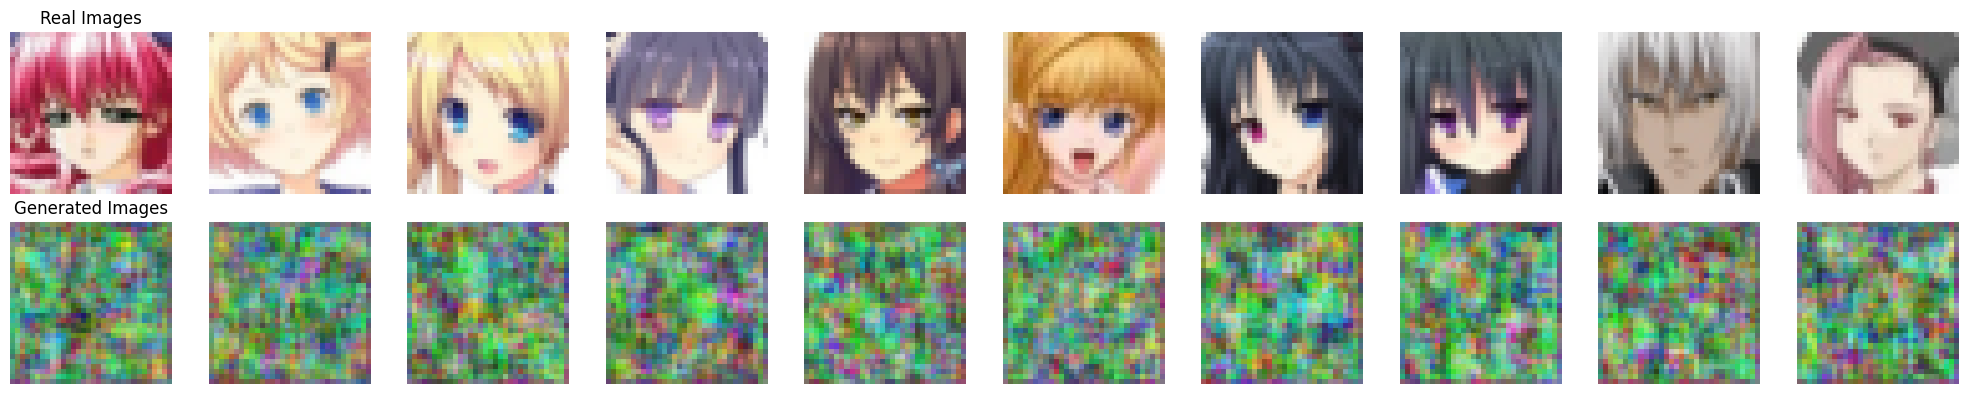

 FID : 428.87437344413297 , IS : 1.0956124067306519
Training started...
[Epoch 1/30] Loss D: -0.0779, Loss G: 0.0441 , FID score : 219.8181 , IS score : 2.8317
[Epoch 2/30] Loss D: -0.0763, Loss G: 0.0435 , FID score : 158.3720 , IS score : 3.4056
[Epoch 3/30] Loss D: -0.0671, Loss G: 0.0392 , FID score : 135.5574 , IS score : 3.3874
[Epoch 4/30] Loss D: -0.0610, Loss G: 0.0363 , FID score : 106.4602 , IS score : 3.1834
[Epoch 5/30] Loss D: -0.0558, Loss G: 0.0338 , FID score : 97.5730 , IS score : 3.2382
[Epoch 6/30] Loss D: -0.0513, Loss G: 0.0318 , FID score : 79.5587 , IS score : 3.0073
[Epoch 7/30] Loss D: -0.0478, Loss G: 0.0301 , FID score : 75.4730 , IS score : 3.2409
[Epoch 8/30] Loss D: -0.0449, Loss G: 0.0288 , FID score : 59.4421 , IS score : 2.8891
[Epoch 9/30] Loss D: -0.0425, Loss G: 0.0273 , FID score : 60.1123 , IS score : 2.9761
[Epoch 10/30] Loss D: -0.0405, Loss G: 0.0263 , FID score : 60.4625 , IS score : 3.1392


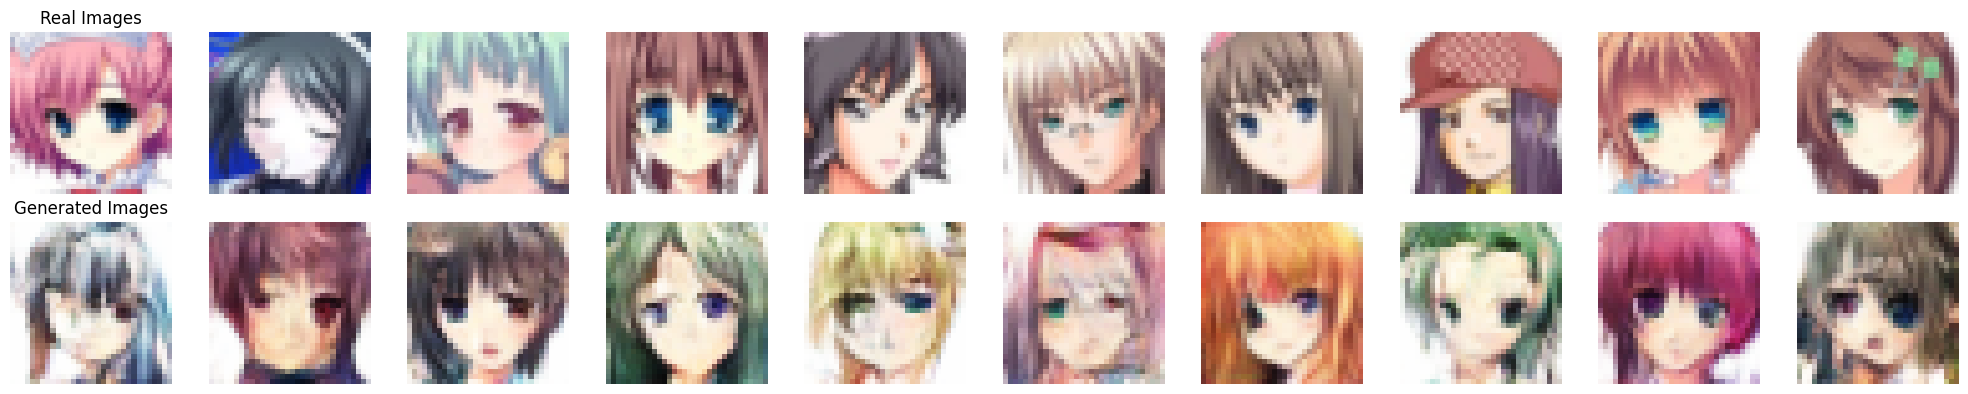

[Epoch 11/30] Loss D: -0.0387, Loss G: 0.0256 , FID score : 62.7189 , IS score : 3.0329
[Epoch 12/30] Loss D: -0.0372, Loss G: 0.0249 , FID score : 57.3078 , IS score : 2.9835
[Epoch 13/30] Loss D: -0.0359, Loss G: 0.0242 , FID score : 49.2980 , IS score : 2.8391
[Epoch 14/30] Loss D: -0.0348, Loss G: 0.0235 , FID score : 49.4218 , IS score : 2.9441
[Epoch 15/30] Loss D: -0.0337, Loss G: 0.0230 , FID score : 44.1306 , IS score : 2.9246
[Epoch 16/30] Loss D: -0.0328, Loss G: 0.0226 , FID score : 52.0862 , IS score : 2.8678
[Epoch 17/30] Loss D: -0.0319, Loss G: 0.0222 , FID score : 53.0374 , IS score : 2.9490
[Epoch 18/30] Loss D: -0.0312, Loss G: 0.0215 , FID score : 36.7846 , IS score : 2.8892
[Epoch 19/30] Loss D: -0.0305, Loss G: 0.0211 , FID score : 52.2890 , IS score : 2.9972
[Epoch 20/30] Loss D: -0.0299, Loss G: 0.0208 , FID score : 41.5412 , IS score : 2.9941


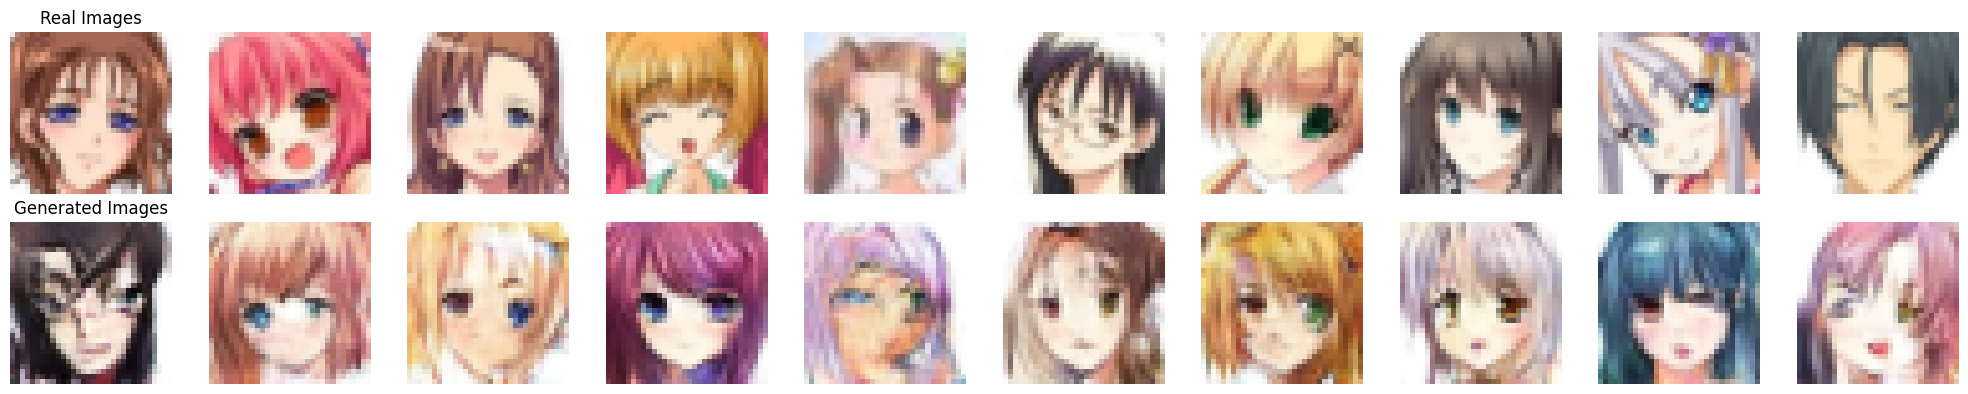

[Epoch 21/30] Loss D: -0.0293, Loss G: 0.0205 , FID score : 48.0585 , IS score : 2.9561
[Epoch 22/30] Loss D: -0.0288, Loss G: 0.0204 , FID score : 42.5707 , IS score : 2.9248
[Epoch 23/30] Loss D: -0.0284, Loss G: 0.0200 , FID score : 44.7949 , IS score : 2.6135
[Epoch 24/30] Loss D: -0.0279, Loss G: 0.0195 , FID score : 36.8521 , IS score : 2.8415
[Epoch 25/30] Loss D: -0.0276, Loss G: 0.0201 , FID score : 35.8762 , IS score : 2.8286
[Epoch 26/30] Loss D: -0.0272, Loss G: 0.0192 , FID score : 44.1226 , IS score : 2.8454
[Epoch 27/30] Loss D: -0.0268, Loss G: 0.0192 , FID score : 38.9164 , IS score : 2.9406
[Epoch 28/30] Loss D: -0.0264, Loss G: 0.0189 , FID score : 44.9640 , IS score : 2.8457
[Epoch 29/30] Loss D: -0.0260, Loss G: 0.0189 , FID score : 37.9366 , IS score : 2.7254
[Epoch 30/30] Loss D: -0.0256, Loss G: 0.0188 , FID score : 34.9438 , IS score : 2.8165


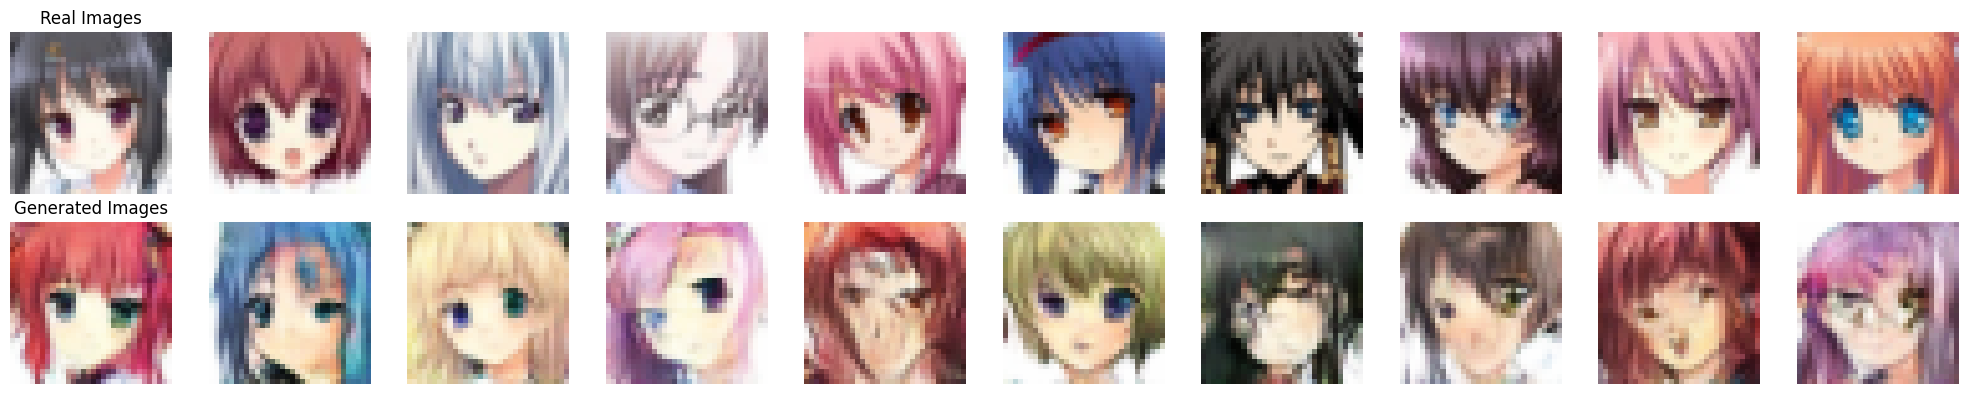

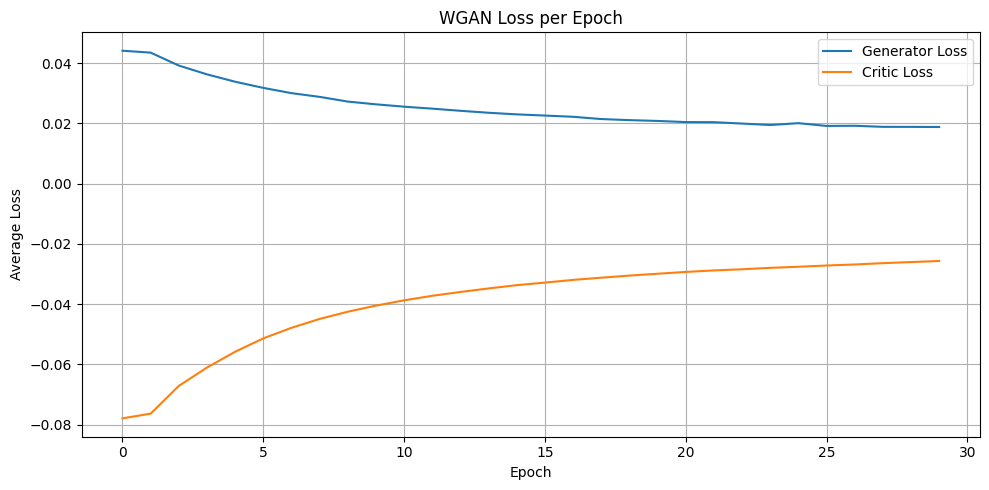

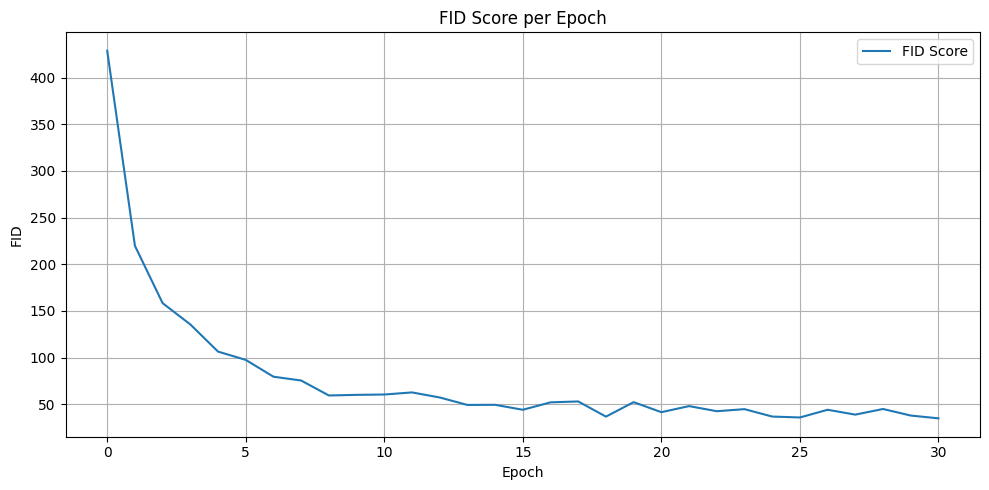

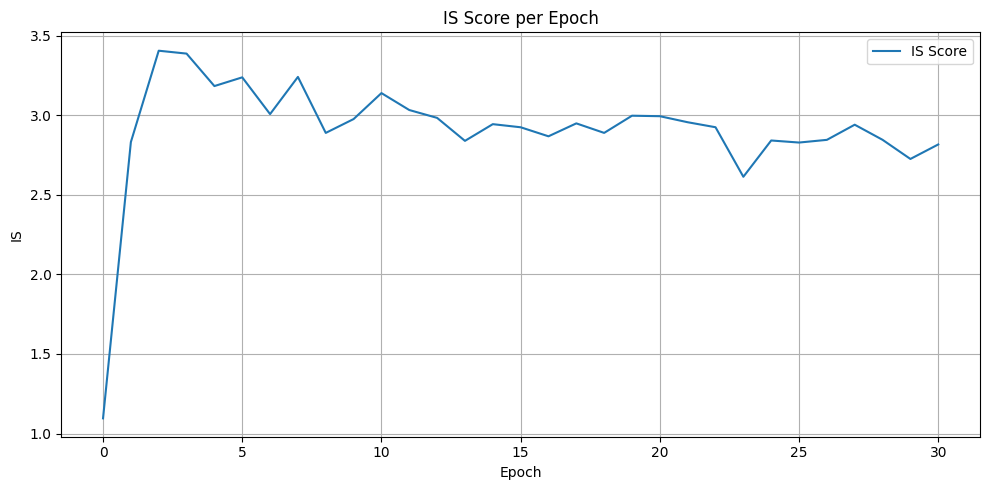

In [18]:
generator_1 = Generator(latent_dim).to(device)
critic_1 = Critic().to(device)
optimizer_g1 = optim.RMSprop(generator_1.parameters(), lr=lr)
optimizer_c1 = optim.RMSprop(critic_1.parameters(), lr=lr)

with torch.no_grad():
    noise = torch.randn(10, latent_dim).to(device)
    gen_imgs = generator_1(noise)

# Get real images for comparison
for imgs, _ in dataloader:
    real_imgs = imgs.to(device)
    break
print("Before Training...")
val1 , val2 , _ = evaluate_metrics(generator_1, dataloader, 5000 , 100 , latent_dim, device)
show_imgs(real_imgs, gen_imgs, n=10)
print(f" FID : {val1} , IS : {val2}")
print("Training started...")

# Start training
train_WGAN(generator_1, critic_1, optimizer_g1, optimizer_c1, dataloader, device, latent_dim, n_critic , c , n_epochs , val1 , val2)

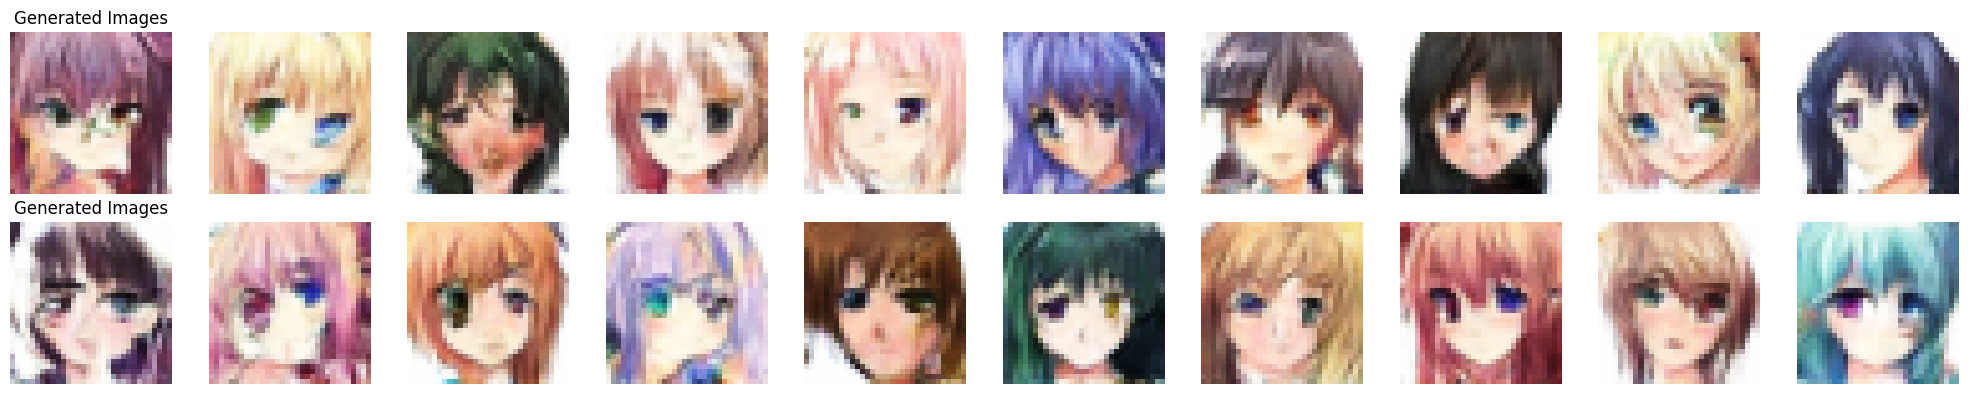

In [ ]:
# Showing the output generated by WGAN
with torch.no_grad():
    noise_1 = torch.randn(10, latent_dim).to(device)
    noise_2 = torch.randn(10, latent_dim).to(device)
    gen_imgs_1 = generator_1(noise_1)
    gen_imgs_2 = generator_1(noise_2)
show_imgs(gen_imgs_1, gen_imgs_2,label=False, n=10)



Before Training...


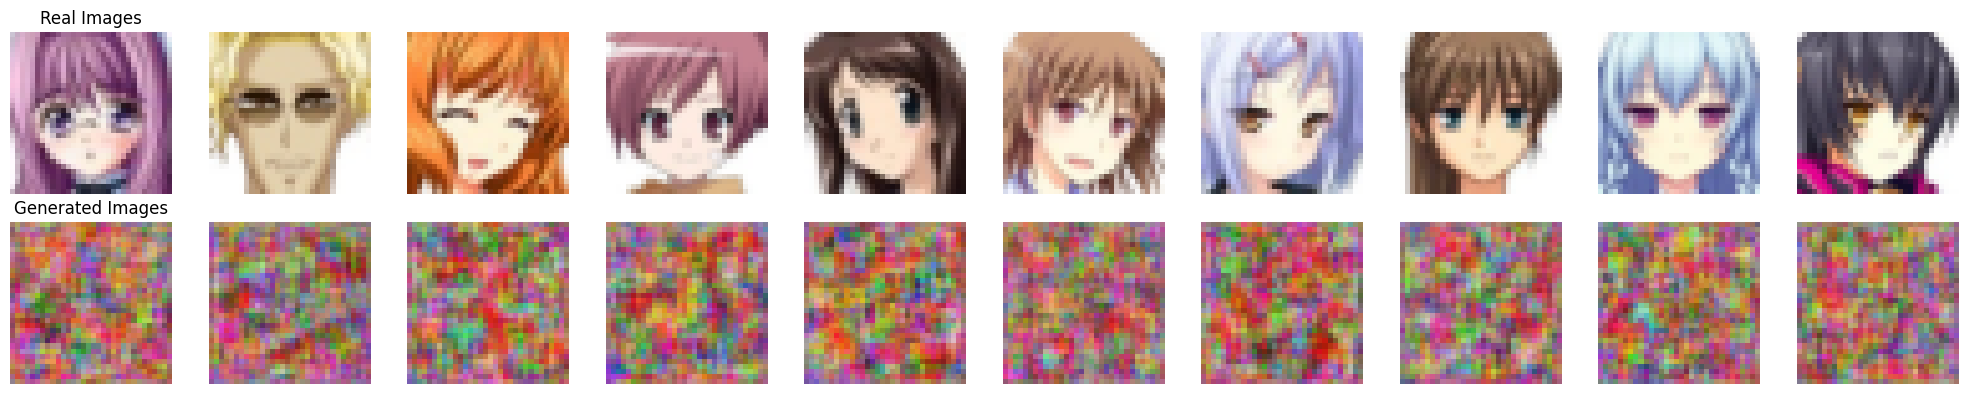

 FID : 423.9007469864454 , IS : 1.0788456201553345
Training started...
[Epoch 1/30] Loss D: 0.8126, Loss G: 1.6185 , FID score : 248.4802
[Epoch 2/30] Loss D: 0.9229, Loss G: 1.4346 , FID score : 228.5187
[Epoch 3/30] Loss D: 0.9806, Loss G: 1.3319 , FID score : 201.8981
[Epoch 4/30] Loss D: 0.9857, Loss G: 1.3270 , FID score : 178.6567
[Epoch 5/30] Loss D: 0.9678, Loss G: 1.3486 , FID score : 171.8809
[Epoch 6/30] Loss D: 0.9603, Loss G: 1.3750 , FID score : 150.4808
[Epoch 7/30] Loss D: 0.9666, Loss G: 1.3829 , FID score : 145.7203
[Epoch 8/30] Loss D: 0.9607, Loss G: 1.3831 , FID score : 121.8475
[Epoch 9/30] Loss D: 0.9612, Loss G: 1.3888 , FID score : 119.2295
[Epoch 10/30] Loss D: 0.9521, Loss G: 1.4054 , FID score : 115.5453


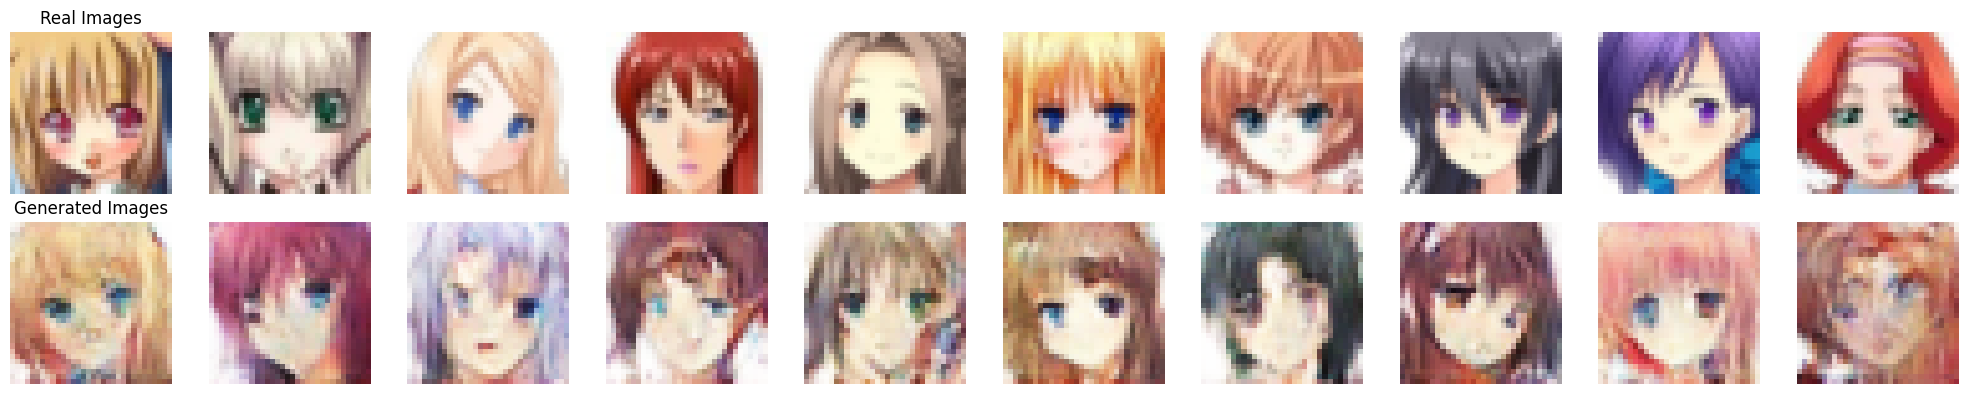

[Epoch 11/30] Loss D: 0.9508, Loss G: 1.4097 , FID score : 112.3223
[Epoch 12/30] Loss D: 0.9510, Loss G: 1.4068 , FID score : 108.4115
[Epoch 13/30] Loss D: 0.9601, Loss G: 1.4023 , FID score : 90.9253
[Epoch 14/30] Loss D: 0.9707, Loss G: 1.3963 , FID score : 96.6076
[Epoch 15/30] Loss D: 0.9734, Loss G: 1.3788 , FID score : 104.7525
[Epoch 16/30] Loss D: 0.9861, Loss G: 1.3775 , FID score : 87.6315
[Epoch 17/30] Loss D: 0.9855, Loss G: 1.3680 , FID score : 77.0469
[Epoch 18/30] Loss D: 0.9848, Loss G: 1.3666 , FID score : 79.3624
[Epoch 19/30] Loss D: 0.9871, Loss G: 1.3574 , FID score : 73.9098
[Epoch 20/30] Loss D: 0.9954, Loss G: 1.3515 , FID score : 70.3685


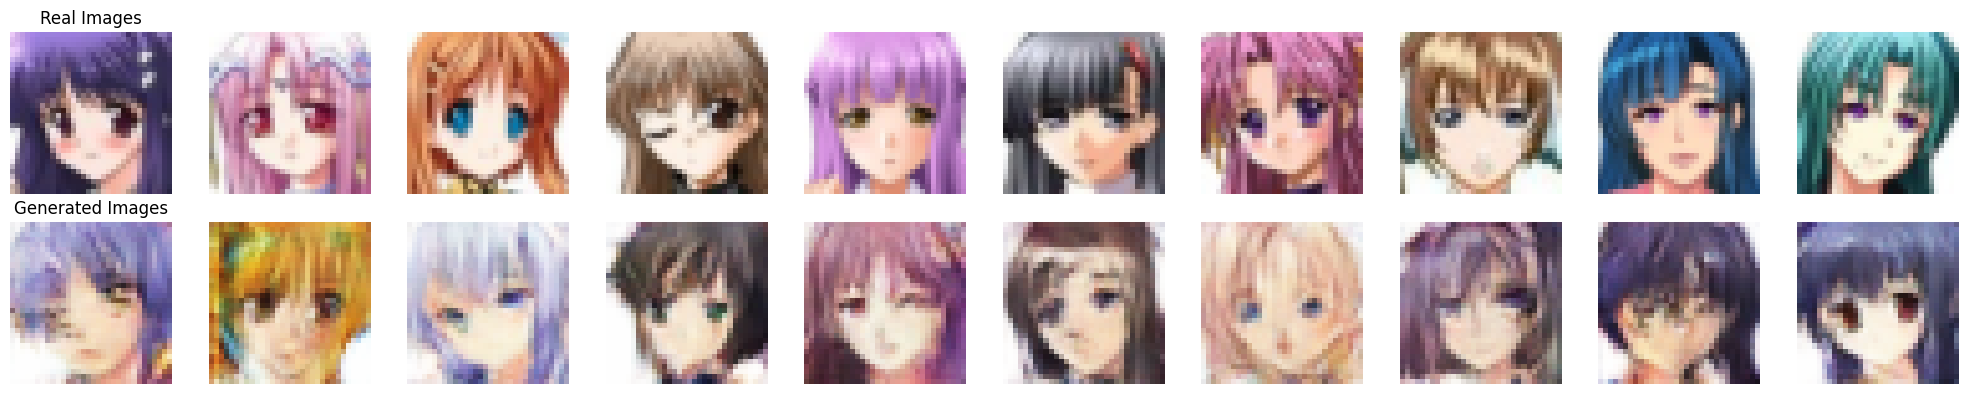

[Epoch 21/30] Loss D: 0.9961, Loss G: 1.3521 , FID score : 68.2508
[Epoch 22/30] Loss D: 0.9939, Loss G: 1.3451 , FID score : 71.2024
[Epoch 23/30] Loss D: 0.9911, Loss G: 1.3450 , FID score : 68.5798
[Epoch 24/30] Loss D: 0.9972, Loss G: 1.3454 , FID score : 54.6737
[Epoch 25/30] Loss D: 0.9943, Loss G: 1.3462 , FID score : 54.6073
[Epoch 26/30] Loss D: 0.9930, Loss G: 1.3428 , FID score : 52.0766
[Epoch 27/30] Loss D: 0.9841, Loss G: 1.3557 , FID score : 69.5431
[Epoch 28/30] Loss D: 0.9870, Loss G: 1.3631 , FID score : 45.0355
[Epoch 29/30] Loss D: 0.9854, Loss G: 1.3574 , FID score : 56.6000
[Epoch 30/30] Loss D: 0.9781, Loss G: 1.3610 , FID score : 52.2729


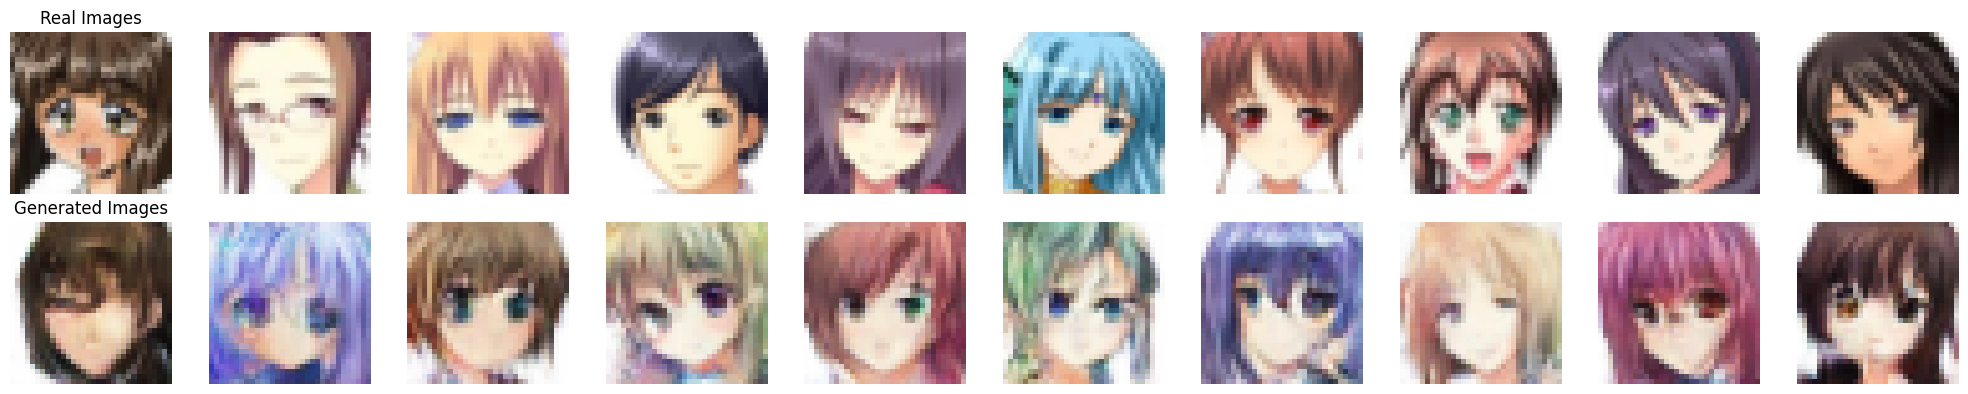

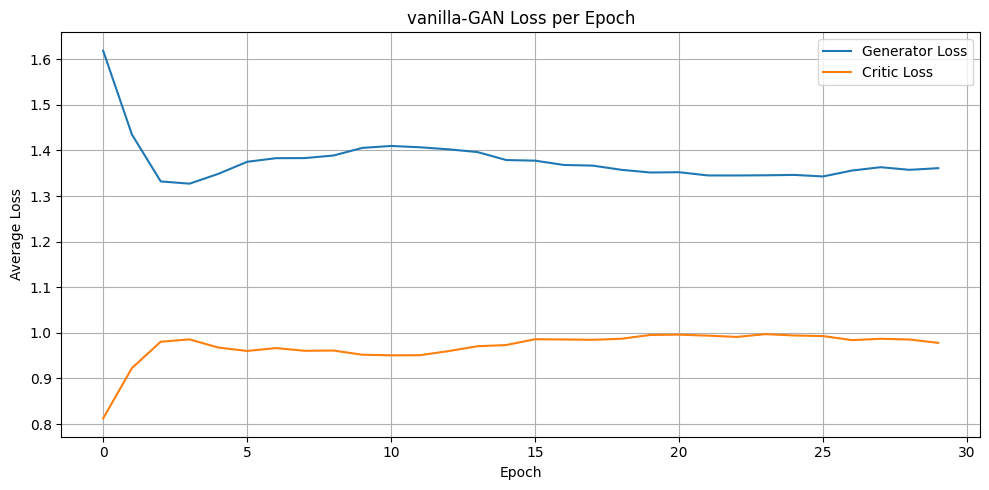

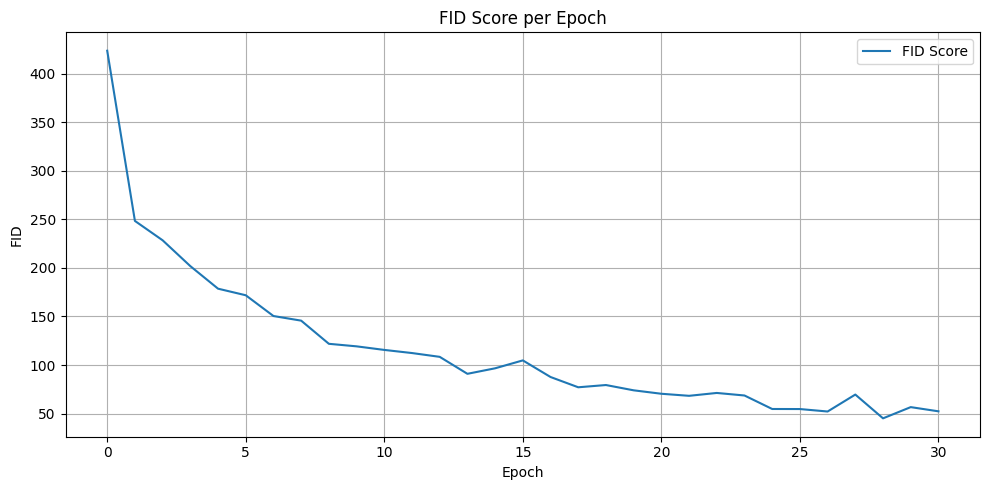

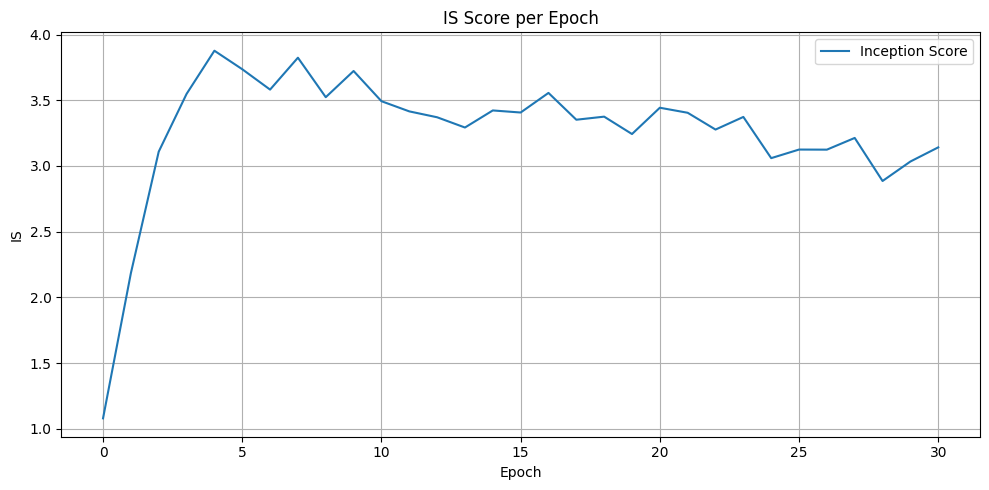

In [11]:
generator_2 = Generator(latent_dim).to(device)
critic_2 = Critic().to(device)
optimizer_g2 = optim.Adam(generator_2.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_c2 = optim.Adam(critic_2.parameters(), lr=lr, betas=(0.5, 0.999))

with torch.no_grad():
    noise = torch.randn(10, latent_dim).to(device)
    gen_imgs = generator_2(noise)

# Get real images for comparison
for imgs, _ in dataloader:
    real_imgs = imgs.to(device)
    break
print("Before Training...")
val1 , val2 , _ = evaluate_metrics(generator_2, dataloader, 5000 , 100 , latent_dim, device)
show_imgs(real_imgs, gen_imgs, n=10)
print(f" FID : {val1} , IS : {val2}")
print("Training started...")

# Start training
train_vanillaGAN(generator_2, critic_2, optimizer_g2, optimizer_c2, dataloader, device, latent_dim, n_epochs , val1 , val2)

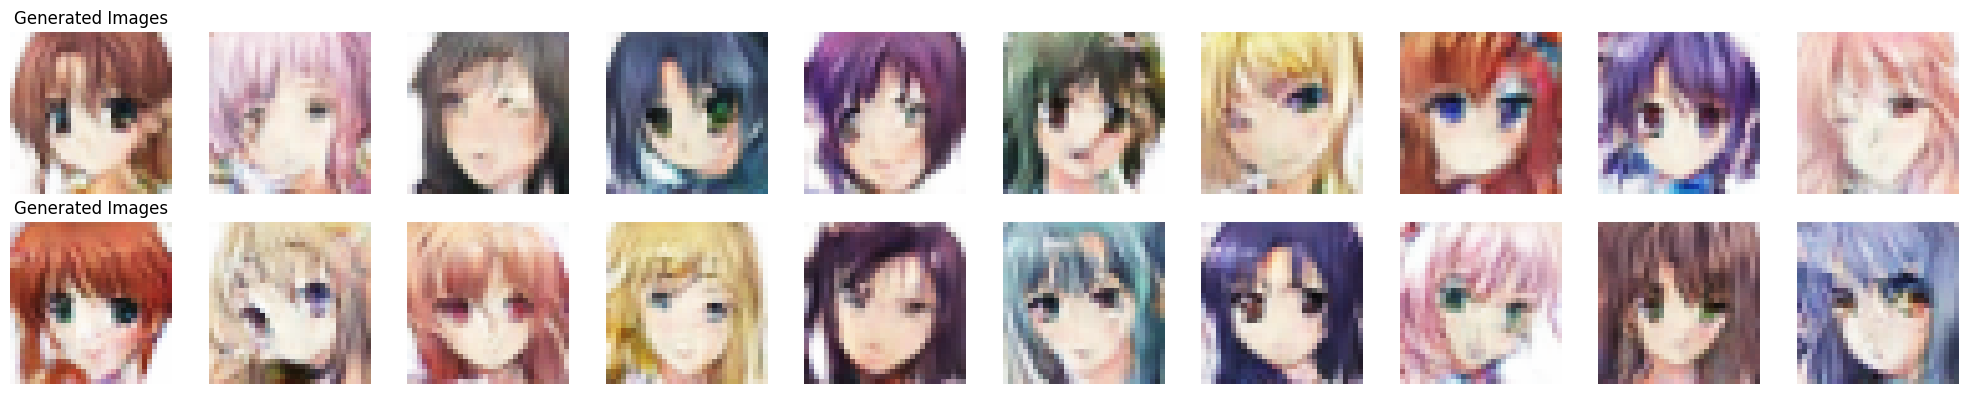

In [ ]:
# Showing the output generated by Vanilla GAN
with torch.no_grad():
    noise_1 = torch.randn(10, latent_dim).to(device)
    noise_2 = torch.randn(10, latent_dim).to(device)
    gen_imgs_1 = generator_2(noise_1)
    gen_imgs_2 = generator_2(noise_2)
show_imgs(gen_imgs_1, gen_imgs_2,label=False, n=10)


Before Training...


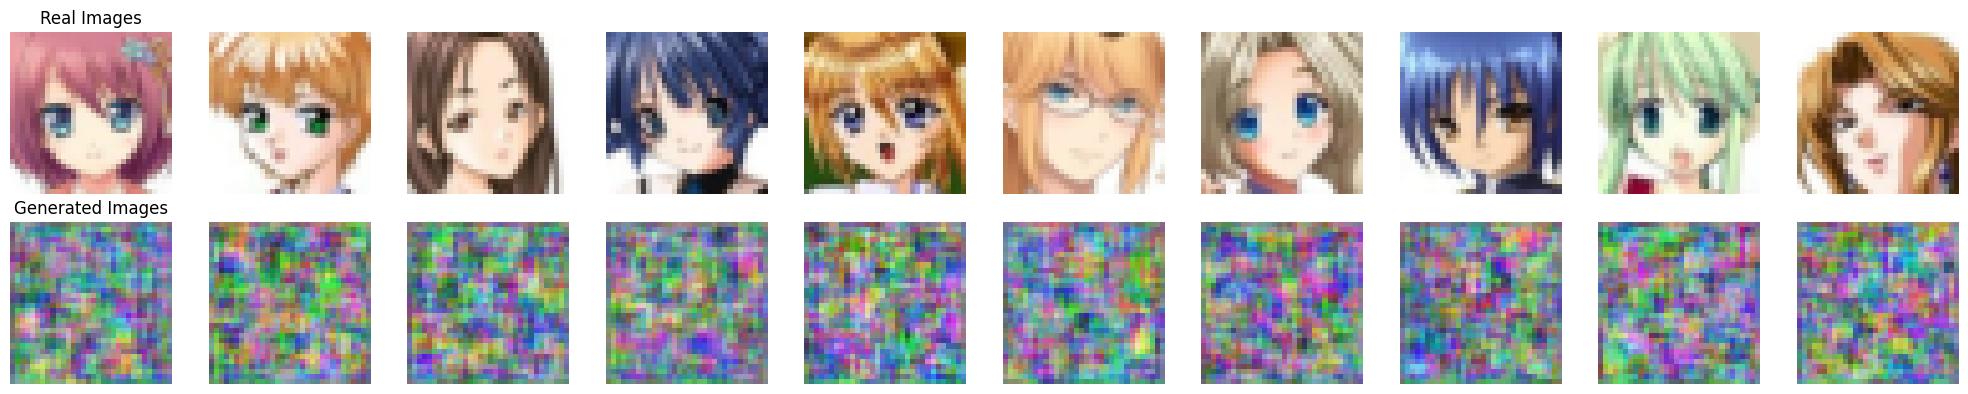

 FID : 436.43370310046976 , IS : 1.0824061632156372
Training started...
[Epoch 1/30] Loss D: -3.7880, Loss G: 1.7785 , FID score : 203.0497 , IS score : 3.4372
[Epoch 2/30] Loss D: -2.4731, Loss G: -0.5928 , FID score : 137.3690 , IS score : 3.6791
[Epoch 3/30] Loss D: -2.1741, Loss G: -1.9623 , FID score : 132.2552 , IS score : 3.6217
[Epoch 4/30] Loss D: -1.9088, Loss G: -3.3575 , FID score : 95.0658 , IS score : 3.4710
[Epoch 5/30] Loss D: -1.7266, Loss G: -4.8657 , FID score : 89.7128 , IS score : 3.1844
[Epoch 6/30] Loss D: -1.6036, Loss G: -6.5439 , FID score : 79.6212 , IS score : 3.2747
[Epoch 7/30] Loss D: -1.5047, Loss G: -7.8937 , FID score : 76.5376 , IS score : 3.3032
[Epoch 8/30] Loss D: -1.4428, Loss G: -8.8716 , FID score : 70.3163 , IS score : 3.2272
[Epoch 9/30] Loss D: -1.3879, Loss G: -9.9809 , FID score : 61.4694 , IS score : 3.2034
[Epoch 10/30] Loss D: -1.3278, Loss G: -11.0098 , FID score : 60.9068 , IS score : 2.9780


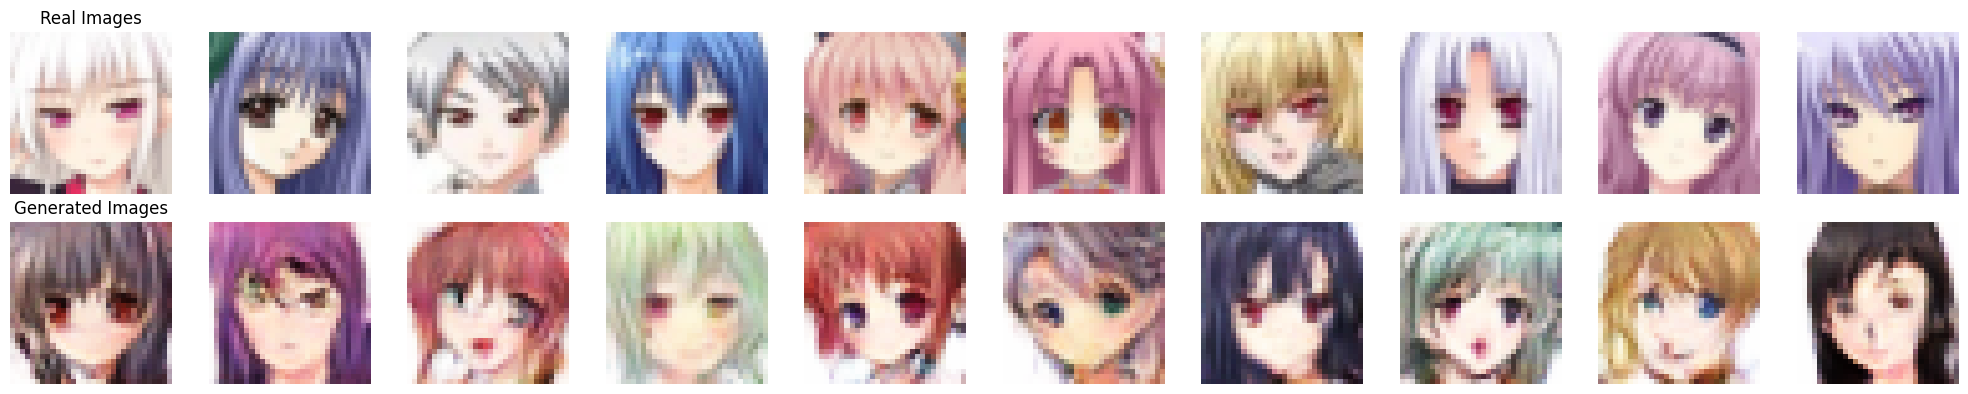

[Epoch 11/30] Loss D: -1.2955, Loss G: -12.2328 , FID score : 52.6827 , IS score : 3.0038
[Epoch 12/30] Loss D: -1.2561, Loss G: -13.0593 , FID score : 44.0099 , IS score : 2.9114
[Epoch 13/30] Loss D: -1.2285, Loss G: -14.1854 , FID score : 48.5974 , IS score : 3.0011
[Epoch 14/30] Loss D: -1.1980, Loss G: -15.0053 , FID score : 48.5818 , IS score : 3.0888
[Epoch 15/30] Loss D: -1.1685, Loss G: -15.9299 , FID score : 46.9228 , IS score : 2.9009
[Epoch 16/30] Loss D: -1.1643, Loss G: -16.6808 , FID score : 45.5953 , IS score : 2.8672
[Epoch 17/30] Loss D: -1.1374, Loss G: -17.3496 , FID score : 42.1967 , IS score : 2.9340
[Epoch 18/30] Loss D: -1.1166, Loss G: -18.1423 , FID score : 38.1377 , IS score : 2.8689
[Epoch 19/30] Loss D: -1.1018, Loss G: -18.6745 , FID score : 47.7029 , IS score : 2.8333
[Epoch 20/30] Loss D: -1.0892, Loss G: -19.3428 , FID score : 51.8424 , IS score : 3.0055


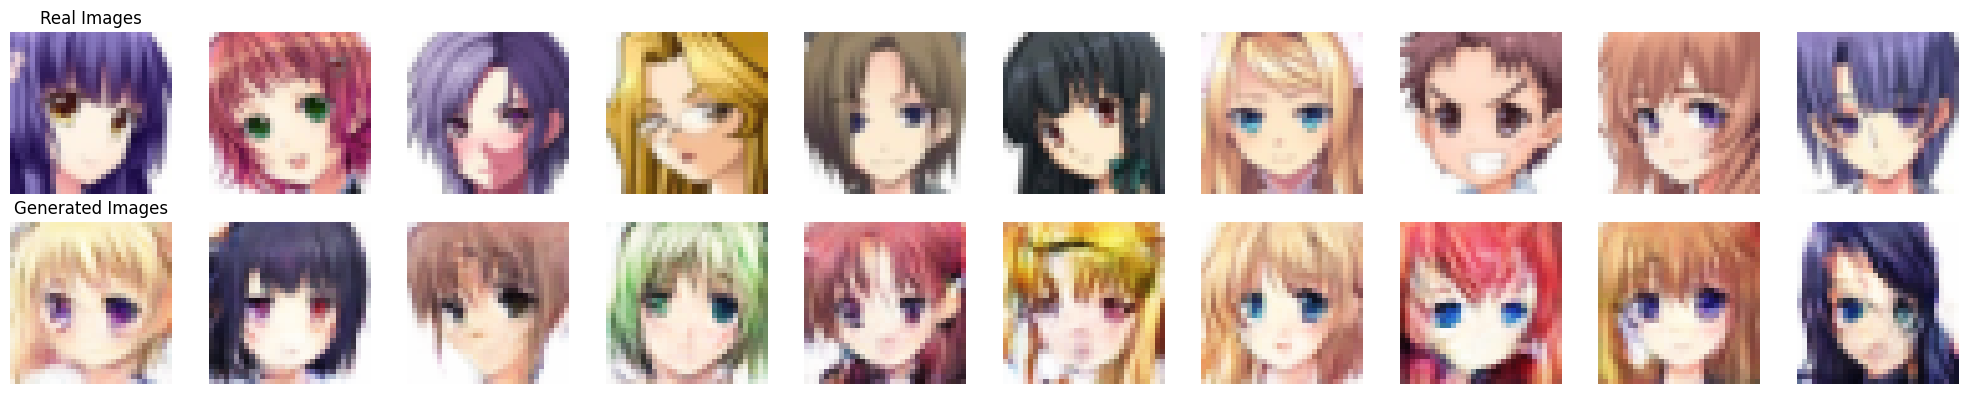

[Epoch 21/30] Loss D: -1.0794, Loss G: -20.1390 , FID score : 41.1229 , IS score : 3.0345
[Epoch 22/30] Loss D: -1.0725, Loss G: -20.6999 , FID score : 34.2759 , IS score : 2.9908
[Epoch 23/30] Loss D: -1.0576, Loss G: -21.3307 , FID score : 38.4036 , IS score : 2.8953
[Epoch 24/30] Loss D: -1.0456, Loss G: -21.9997 , FID score : 39.7424 , IS score : 2.9635
[Epoch 25/30] Loss D: -1.0356, Loss G: -22.8348 , FID score : 41.7404 , IS score : 3.1624
[Epoch 26/30] Loss D: -1.0246, Loss G: -23.5362 , FID score : 36.6224 , IS score : 2.9113
[Epoch 27/30] Loss D: -1.0173, Loss G: -24.1143 , FID score : 36.8961 , IS score : 2.9895
[Epoch 28/30] Loss D: -1.0081, Loss G: -24.5892 , FID score : 39.8928 , IS score : 3.0312
[Epoch 29/30] Loss D: -0.9950, Loss G: -24.8162 , FID score : 28.0753 , IS score : 2.8307
[Epoch 30/30] Loss D: -0.9768, Loss G: -25.4600 , FID score : 27.8479 , IS score : 2.6718


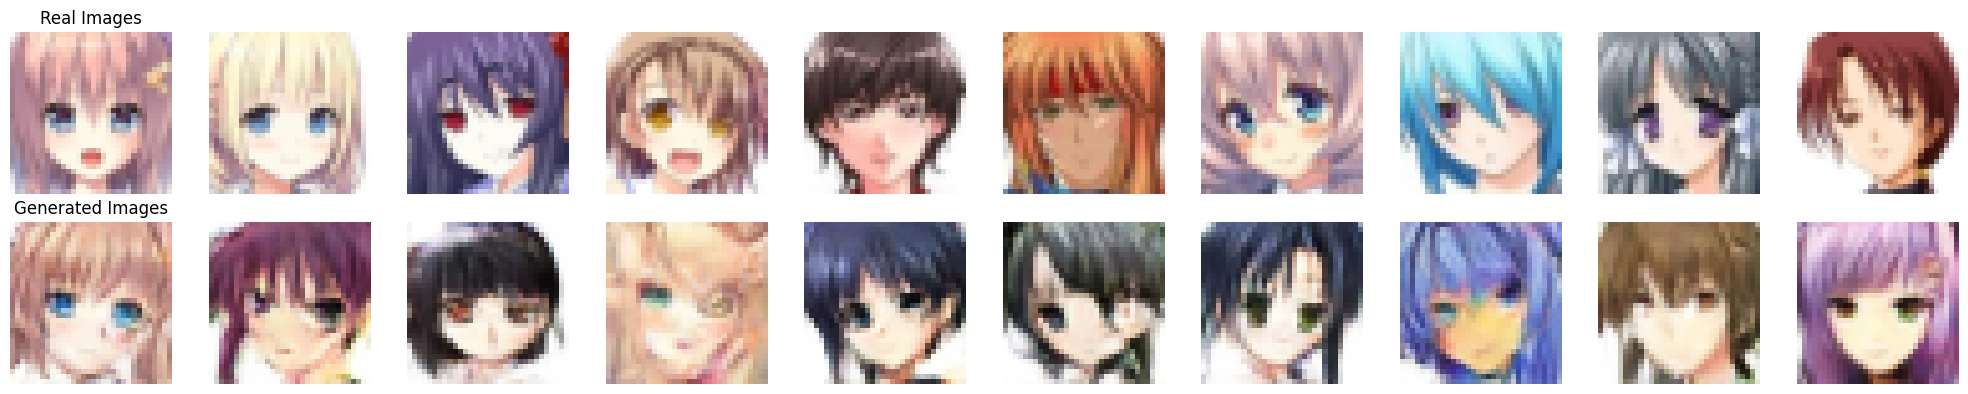

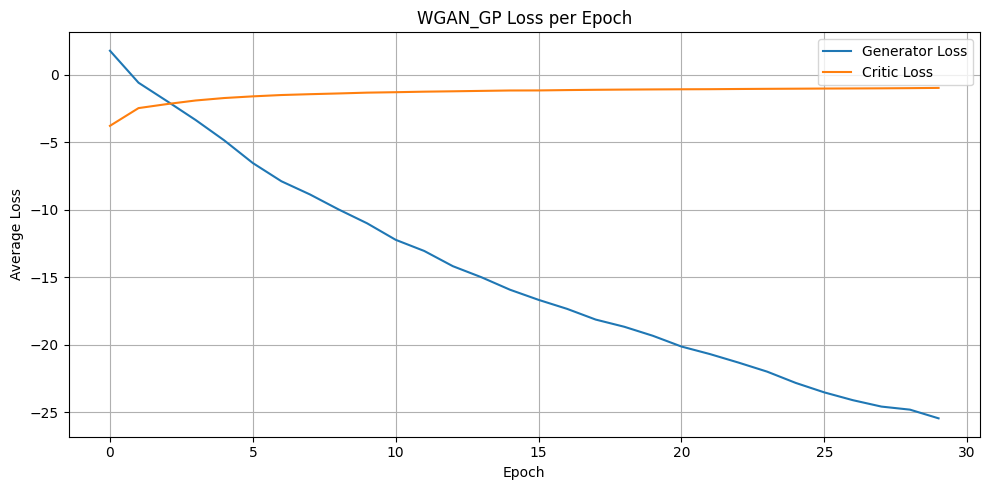

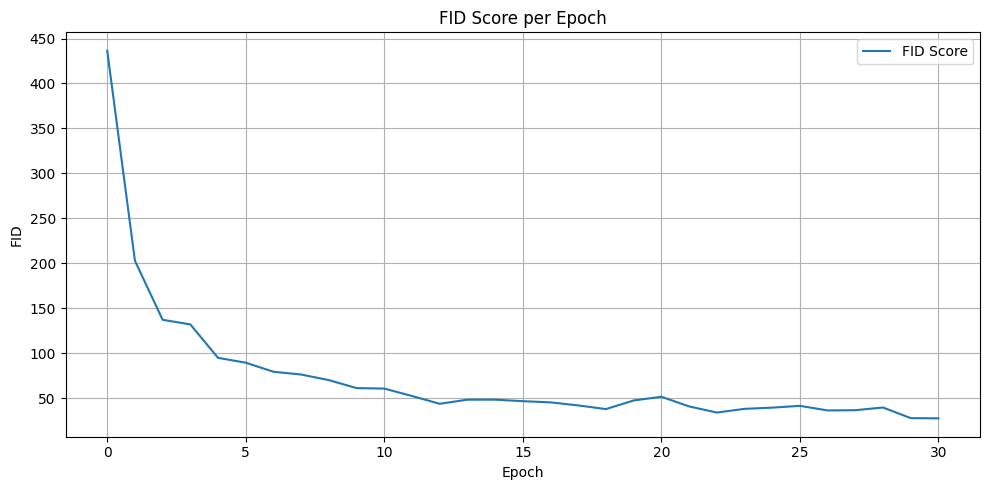

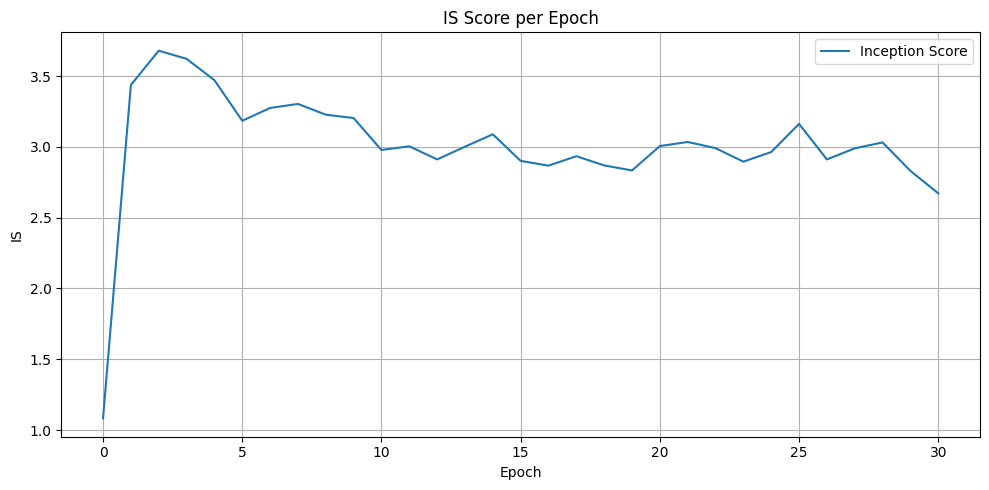

In [58]:
generator_3 = Generator(latent_dim).to(device)
critic_3 = Critic().to(device)
optimizer_g3 = optim.Adam(generator_3.parameters(), lr=1e-4, betas=(0.0, 0.9))
optimizer_c3 = optim.Adam(critic_3.parameters(), lr=1e-4, betas=(0.0, 0.9))

with torch.no_grad():
    noise = torch.randn(10, latent_dim).to(device)
    gen_imgs = generator_3(noise)

# Get real images for comparison
for imgs, _ in dataloader:
    real_imgs = imgs.to(device)
    break
print("Before Training...")
val1 , val2 , _ = evaluate_metrics(generator_3, dataloader, 5000 , 100 , latent_dim, device)
show_imgs(real_imgs, gen_imgs, n=10)
print(f" FID : {val1} , IS : {val2}")
print("Training started...")

# Start training
train_WGAN_GP(generator_3, critic_3, optimizer_g3, optimizer_c3, dataloader, device, latent_dim,n_critic , l , n_epochs , val1 , val2)

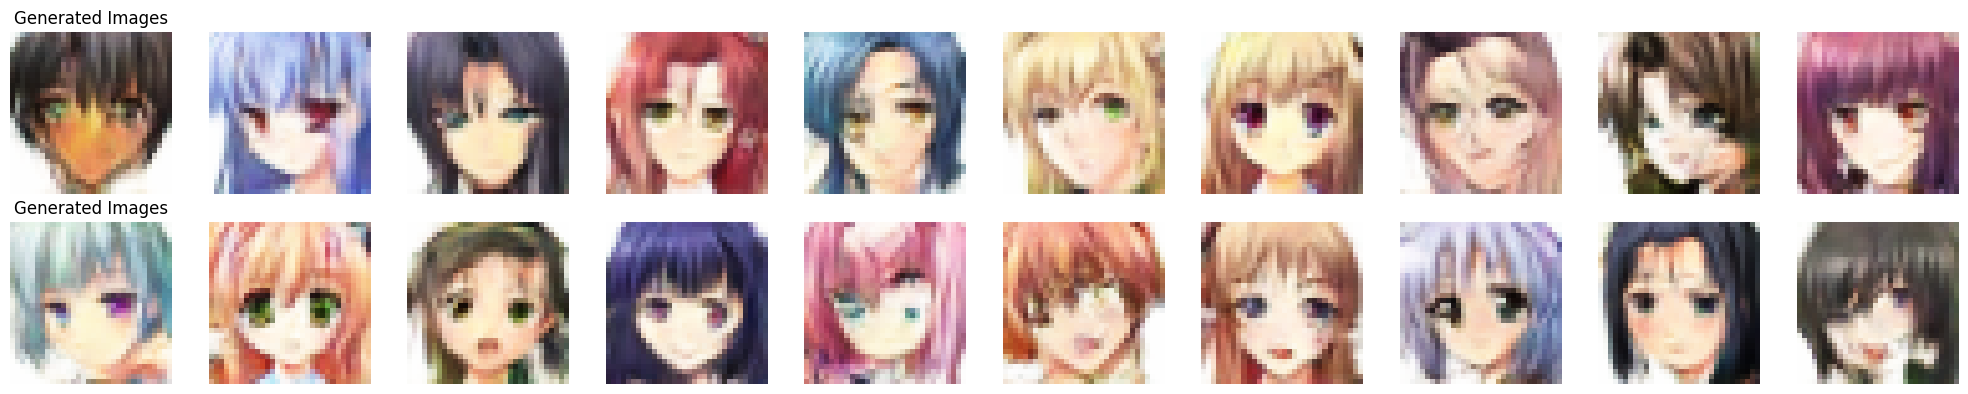

In [ ]:
# Showing the output generated by WGAN-GP
with torch.no_grad():
    noise_1 = torch.randn(10, latent_dim).to(device)
    noise_2 = torch.randn(10, latent_dim).to(device)
    gen_imgs_1 = generator_3(noise_1)
    gen_imgs_2 = generator_3(noise_2)
show_imgs(gen_imgs_1, gen_imgs_2,label=False, n=10)